# Microcanonical Langevin Monte Carlo

This is an algorithm based on https://arxiv.org/abs/2212.08549 ({cite:p}`robnik2023microcanonical`, {cite:p}`robnik2023microcanonical2`). A website with detailed information can be found [here](https://microcanonical-monte-carlo.netlify.app/). The algorithm is provided in both adjusted (i.e. with an Metropolis-Hastings step) and unadjusted versions; by default we use "MCLMC" to refer to the unadjusted version.

The original derivation comes from thinking about the microcanonical ensemble (a concept from statistical mechanics), but the upshot is that we integrate the following SDE:

$$
\frac{d}{dt}\begin{bmatrix}
x \\
u
\end{bmatrix}
=
\begin{bmatrix}
u \\
-P(u)(\nabla S(x)/(d − 1)) + \eta P(u)dW
\end{bmatrix}
$$

where $u$ is an auxilliary variable, $S(x)$ is the negative log PDF of the distribution from which we are sampling and the last term describes spherically symmetric noise. After $u$ is marginalized out, this converges to the target PDF, $p(x) \propto e^{-S(x)}$.

## How to run MCLMC in BlackJax

It is very important to use the tuning algorithm provided, which controls the step size of the integrator and also $L$, a parameter related to $\eta$ above.

An example is given below, of a 1000 dim Gaussian (of which 2 dimensions are plotted).

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

In [2]:
import jax

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [3]:
import blackjax
import numpy as np
import jax.numpy as jnp

In [18]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov_mat : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov_mat=sqrt_diag_cov_mat,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples, _ = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples

In [9]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(rng_key)
samples = run_mclmc(
    logdensity_fn=lambda x: -0.5 * jnp.sum(jnp.square(x)),
    num_steps=1000,
    initial_position=jnp.ones((1000,)),
    key=sample_key,
    transform=lambda x: x.position[:2],
)
samples.mean()

Array(-0.00678285, dtype=float32)

Text(0.5, 1.0, 'Scatter Plot of Samples')

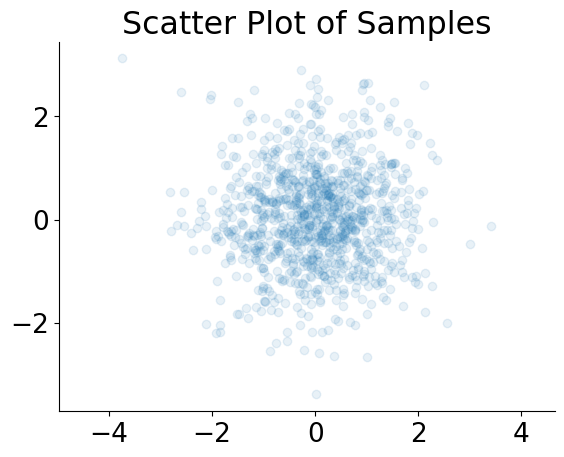

In [12]:
plt.scatter(x=samples[:, 0], y=samples[:, 1], alpha=0.1)
plt.axis("equal")
plt.title("Scatter Plot of Samples")

# Second example: Stochastic Volatility

This is ported from Jakob Robnik's [example notebook](https://github.com/JakobRobnik/MicroCanonicalHMC/blob/master/notebooks/tutorials/advanced_tutorial.ipynb)

Text(0, 0.5, 'S&P500 returns')

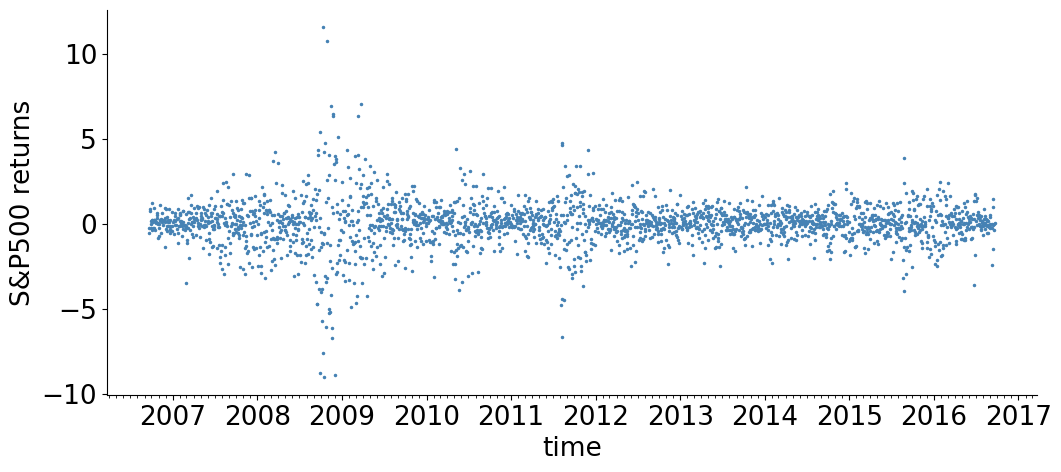

In [15]:
import matplotlib.dates as mdates

from numpyro.examples.datasets import SP500, load_dataset
from numpyro.distributions import StudentT

# get the data
_, fetch = load_dataset(SP500, shuffle=False)
SP500_dates, SP500_returns = fetch()


# figure setup
_, ax = plt.subplots(figsize=(12, 5))
ax.spines["right"].set_visible(False)  # remove the upper and the right axis lines
ax.spines["top"].set_visible(False)

ax.xaxis.set_major_locator(mdates.YearLocator())  # dates on the xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# plot data
dates = mdates.num2date(mdates.datestr2num(SP500_dates))
ax.plot(dates, SP500_returns, ".", markersize=3, color="steelblue")
ax.set_xlabel("time")
ax.set_ylabel("S&P500 returns")

In [16]:
dim = 2429

lambda_sigma, lambda_nu = 50, 0.1


def logp_volatility(x):
    """log p of the target distribution"""

    sigma = (
        jnp.exp(x[-2]) / lambda_sigma
    )  # we used log-transformation to make x unconstrained
    nu = jnp.exp(x[-1]) / lambda_nu

    prior2 = (jnp.exp(x[-2]) - x[-2]) + (
        jnp.exp(x[-1]) - x[-1]
    )  # - log prior(sigma, nu)
    prior1 = (dim - 2) * jnp.log(sigma) + 0.5 * (
        jnp.square(x[0]) + jnp.sum(jnp.square(x[1:-2] - x[:-3]))
    ) / jnp.square(
        sigma
    )  # - log prior(R)
    lik = -jnp.sum(
        StudentT(df=nu, scale=jnp.exp(x[:-2])).log_prob(SP500_returns)
    )  # - log likelihood

    return -(lik + prior1 + prior2)


def transform(x):
    """transform x back to the parameters R, sigma and nu (taking the exponent)"""

    Rn = jnp.exp(x[:-2])
    sigma = jnp.exp(x[-2]) / lambda_sigma
    nu = jnp.exp(x[-1]) / lambda_nu

    return jnp.concatenate((Rn, jnp.array([sigma, nu])))


def prior_draw(key):
    """draws x from the prior"""

    key_walk, key_exp1, key_exp2 = jax.random.split(key, 3)

    sigma = (
        jax.random.exponential(key_exp1) / lambda_sigma
    )  # sigma is drawn from the exponential distribution

    def step(track, useless):  # one step of the gaussian random walk
        randkey, subkey = jax.random.split(track[1])
        x = (
            jax.random.normal(subkey, shape=track[0].shape, dtype=track[0].dtype)
            + track[0]
        )
        return (x, randkey), x

    x = jnp.empty(dim)
    x = x.at[:-2].set(
        jax.lax.scan(step, init=(0.0, key_walk), xs=None, length=dim - 2)[1] * sigma
    )  # = log R_n are drawn as a Gaussian random walk realization
    x = x.at[-2].set(
        jnp.log(sigma * lambda_sigma)
    )  # sigma ~ exponential distribution(lambda_sigma)
    x = x.at[-1].set(
        jnp.log(jax.random.exponential(key_exp2))
    )  # nu ~ exponential distribution(lambda_nu)

    return x

In [15]:
key1, key2, rng_key = jax.random.split(rng_key, 3)
samples = run_mclmc(
    logdensity_fn=logp_volatility,
    num_steps=10000,
    initial_position=prior_draw(key1),
    key=key2,
    transform=lambda x: x,
)

samples = transform(samples.position)

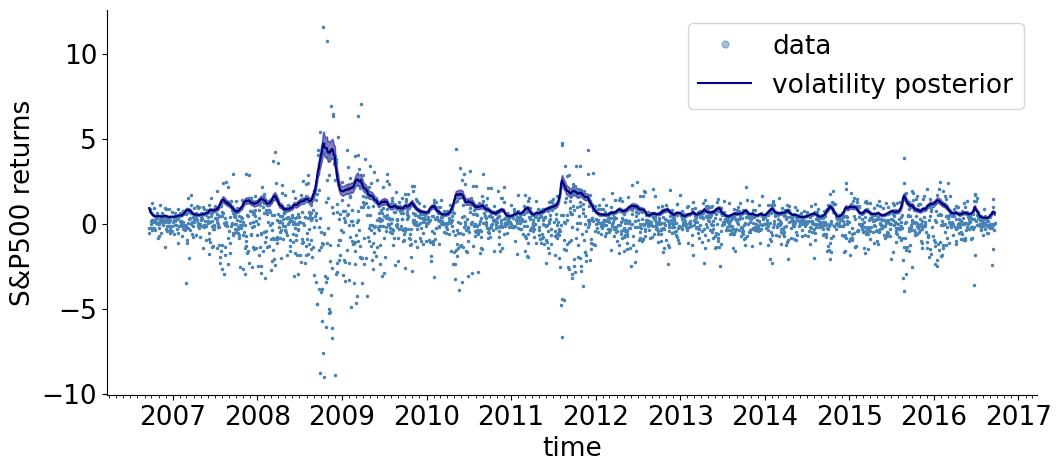

In [16]:
R = np.array(samples)[:, :-2]  # remove sigma and nu parameters
R = np.sort(R, axis=0)  # sort samples for each R_n
num_samples = len(R)
lower_quartile, median, upper_quartile = (
    R[num_samples // 4, :],
    R[num_samples // 2, :],
    R[3 * num_samples // 4, :],
)

# figure setup
_, ax = plt.subplots(figsize=(12, 5))
ax.spines["right"].set_visible(False)  # remove the upper and the right axis lines
ax.spines["top"].set_visible(False)

ax.xaxis.set_major_locator(mdates.YearLocator())  # dates on the xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# plot data
ax.plot(dates, SP500_returns, ".", markersize=3, color="steelblue")
ax.plot(
    [], [], ".", markersize=10, color="steelblue", alpha=0.5, label="data"
)  # larger markersize for the legend
ax.set_xlabel("time")
ax.set_ylabel("S&P500 returns")

# plot posterior
ax.plot(dates, median, color="navy", label="volatility posterior")
ax.fill_between(dates, lower_quartile, upper_quartile, color="navy", alpha=0.5)

ax.legend()

## Adjusted MCLMC

Blackjax also provides an adjusted version of the algorithm. This also has two hyperparameters, `step_size` and `L`. `L` is related to the `L` parameter of the unadjusted version, but not identical. The tuning algorithm is also similar, but uses a dual averaging scheme to tune the step size. We find in practice that a target MH acceptance rate of 0.9 is a good choice.

In [23]:
from blackjax.mcmc.adjusted_mclmc import rescale

def run_adjusted_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.adjusted_mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, random_generator_arg=init_key
    )

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, sqrt_diag_cov_mat: blackjax.mcmc.adjusted_mclmc.build_kernel(
                integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
                integration_steps_fn = lambda k : jnp.ceil(jax.random.uniform(k) * rescale(avg_num_integration_steps)),
                sqrt_diag_cov_mat=sqrt_diag_cov_mat,
            )(
                rng_key=rng_key, 
                state=state, 
                step_size=step_size, 
                logdensity_fn=logdensity_fn)
    
    
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        params_history,
        final_da
    ) = blackjax.adaptation.mclmc_adaptation.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=0.9,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1,
        diagonal_preconditioning=False,
    )



    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L
    # jax.debug.print("params {x}", x=(blackjax_mclmc_sampler_params.step_size, blackjax_mclmc_sampler_params.L))


    alg = blackjax.adjusted_mclmc(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn = lambda key: jnp.ceil(jax.random.uniform(key) * rescale(L/step_size)) ,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov_mat=blackjax_mclmc_sampler_params.sqrt_diag_cov_mat,
        

    )


    _, samples, info = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps, 
        transform=lambda x: x.position, 
        progress_bar=True)
    return samples

Text(0.5, 1.0, 'Scatter Plot of Samples')

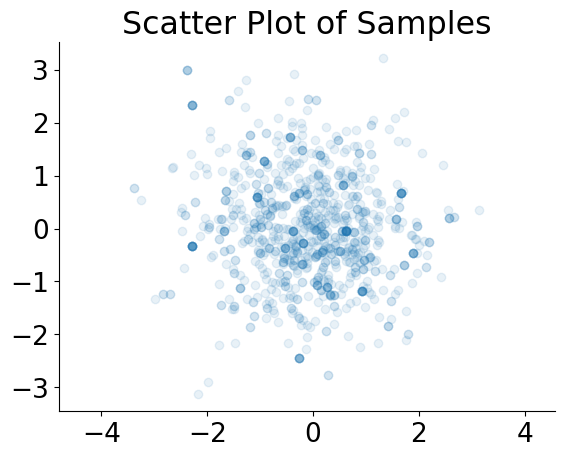

In [20]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(rng_key)
samples = run_adjusted_mclmc(
    logdensity_fn=lambda x: -0.5 * jnp.sum(jnp.square(x)),
    num_steps=1000,
    initial_position=jnp.ones((1000,)),
    key=sample_key,
    transform=lambda x: x.position[:2],
)
plt.scatter(x=samples[:, 0], y=samples[:, 1], alpha=0.1)
plt.axis("equal")
plt.title("Scatter Plot of Samples")

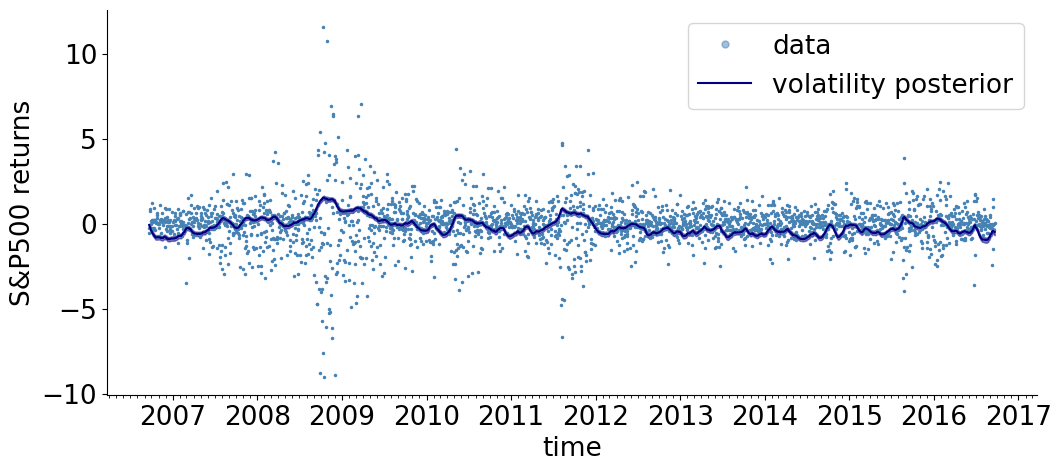

In [24]:
key1, key2, rng_key = jax.random.split(rng_key, 3)
samples = run_adjusted_mclmc(
    logdensity_fn=logp_volatility,
    num_steps=10000,
    initial_position=prior_draw(key1),
    key=key2,
    transform=lambda x: x,
)

R = np.array(samples)[:, :-2]  # remove sigma and nu parameters
R = np.sort(R, axis=0)  # sort samples for each R_n
num_samples = len(R)
lower_quartile, median, upper_quartile = (
    R[num_samples // 4, :],
    R[num_samples // 2, :],
    R[3 * num_samples // 4, :],
)

# figure setup
_, ax = plt.subplots(figsize=(12, 5))
ax.spines["right"].set_visible(False)  # remove the upper and the right axis lines
ax.spines["top"].set_visible(False)

ax.xaxis.set_major_locator(mdates.YearLocator())  # dates on the xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# plot data
ax.plot(dates, SP500_returns, ".", markersize=3, color="steelblue")
ax.plot(
    [], [], ".", markersize=10, color="steelblue", alpha=0.5, label="data"
)  # larger markersize for the legend
ax.set_xlabel("time")
ax.set_ylabel("S&P500 returns")

# plot posterior
ax.plot(dates, median, color="navy", label="volatility posterior")
ax.fill_between(dates, lower_quartile, upper_quartile, color="navy", alpha=0.5)

ax.legend()

```{bibliography}
:filter: docname in docnames
```


```